In [53]:
%%writefile image_util.py

import torch.nn as nn
from torchvision.datasets import SVHN
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, save, load, from_numpy
import numpy as np

import cv2 as cv
import os

import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) # 1 input image channel, 6 output channels, 3x3 square convolution kernel
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1   = nn.Linear(16*6*6, 128) # an affine operation: y = Wx + b
        self.fc2   = nn.Linear(128, 64)
        self.fc3   = nn.Linear(64, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # If the size is a square you can only specify a single number
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

from PIL import Image, ImageOps
def pad_img(img):
    desired_sz = 32
    w, h = img.size
    resize_ratio = desired_sz * 1.0 / max(w, h)
    img = img.resize((int(w*resize_ratio), int(h*resize_ratio)))
    
    #pad image to make 32x32
    w, h = img.size
    delta_w = desired_sz - w
    delta_h = desired_sz - h
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    return ImageOps.expand(
        img, 
        padding
    )

def proc_fn(x):
    return transforms.Normalize([0.5], [0.5])(transforms.ToTensor()(x.convert('L')))

def preproc_pil_img(img):
    # gray, norm, tensor
    return proc_fn(pad_img(img))

def file2tensor(file_path):
    aa = preproc_pil_img(Image.open(file_path))
    c, w, h = aa.size()
    aa = aa.view((1, c, w, h))
    return aa

def cv2tensor(img):
    if len(img.shape) > 2:
        img = cv.cvtColor(img,cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img)
    aa = preproc_pil_img(pil_img)
    c, w, h = aa.size()
    aa = aa.view((1, c, w, h))
    return aa
    
def predict_image(tensor, model):
    output = model(Variable(tensor))
    return np.exp(output.data.numpy())
#     print(np.exp(output.data.numpy()))
#     return np.argmax(output.data.numpy(), axis=1)

Overwriting image_util.py


In [51]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# the folder is structured in the following way:
#     -- data_folder
#         -- label1
#             -- image1
#             -- image2
#             -- ..
#         -- label2
#             -- image1
#             -- ..
#         -- ..
class LabeledDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data = []
        for x in os.listdir(data_folder):
            # list label folders
            x_path = os.path.join(data_folder, x)
            if os.path.isdir(x_path):
                # list images in label folder
                for y in os.listdir(x_path):
                    if self._is_img(y):
                        img = Image.open(os.path.join(x_path, y))
                        self.data.append((transform(img), int(x)))
            
        
    
    def __getitem__(self, index):
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        # 2. Preprocess the data (e.g. torchvision.Transform).
        # 3. Return a data pair (e.g. image and label).
        #这里需要注意的是，第一步：read one data，是一个data
        return self.data[index]
    def __len__(self):
        # You should change 0 to the total size of your dataset.
        return len(self.data)
    
    def _is_img(self, file_path):
        return any([file_path.endswith(ext) for ext in ('.jpg', '.jpeg', '.png')])

In [3]:
# copy from original data source to cropped labeled folder
from digitStruct import *
root = '/Users/jtao/Downloads/test'
dsFileName = os.path.join(root, 'digitStruct.mat')
data_agg = root + '_agg'
if not os.path.exists(data_agg):
    os.mkdir(data_agg)
testCounter = 0
for dsObj in yieldNextDigitStruct(dsFileName):
    break
    testCounter += 1
    if not testCounter % 1000:
        print(testCounter)
#     print(dsObj.name)
    img_file_path = os.path.join(root, dsObj.name)
    img = Image.open(img_file_path)
    for bbox in dsObj.bboxList:
#         print("    {}:{},{},{},{}".format(
#             bbox.label, bbox.left, bbox.top, bbox.width, bbox.height))
        label_dir = os.path.join(data_agg, str(bbox.label))
        if not os.path.exists(label_dir):
            os.mkdir(label_dir)
        cropped = img.crop((bbox.left, bbox.top, bbox.left+bbox.width, bbox.top+bbox.height))
        padded = pad_img(cropped)
        padded.save(os.path.join(label_dir, str(dsObj.name) + '_' + str(bbox.left) + '_' + str(bbox.top) + '.png'))
        
    

In [6]:
pwd = %pwd
proc_fn = lambda x: transforms.Normalize([0.5], [0.5])(transforms.ToTensor()(x.convert('L')))
# data = SVHN(
#     pwd, 
#     download=True, 
#     transform=proc_fn,
# )
data = LabeledDataset('/Users/jtao/Downloads/train_agg/', transform=proc_fn)
# np.place(data.labels, data.labels == 10, 0)

In [7]:
pwd = %pwd
# test = SVHN(
#     pwd, 
#     split='test',
#     download=True, 
#     transform=proc_fn,
# )
test = LabeledDataset('/Users/jtao/Downloads/test_agg/', transform=proc_fn)
# np.place(test.labels, test.labels == 10, 0)

In [8]:
train_loader = DataLoader(dataset=data,
                               batch_size=100,# 这里定义了batch_size
                               shuffle=True,
                               num_workers=2)
test_loader = DataLoader(dataset=test,
                               batch_size=100,# 这里定义了batch_size
                               shuffle=True,
                               num_workers=2)

In [26]:
# 迭代开始，然后，队列和线程跟着也开始
data_iter = iter(train_loader)

# mini-batch 图像 和 标签
images, labels = next(data_iter)

In [31]:
labels


 4
 3
 6
 0
 8
 4
 7
 4
 0
 2
 5
 1
 4
 9
 1
 4
 4
 4
 1
 3
 7
 6
 1
 6
 2
 8
 1
 4
 1
 1
 1
 2
 1
 1
 0
 1
 5
 8
 4
 7
 3
 9
 5
 2
 2
 3
 7
 3
 0
 3
 4
 6
 0
 5
 2
 8
 4
 9
 1
 3
 7
 3
 3
 2
 9
 9
 3
 3
 3
 5
 4
 4
 5
 3
 8
 9
 1
 4
 4
 9
 7
 2
 0
 2
 1
 2
 5
 1
 7
 4
 5
 1
 5
 1
 4
 0
 7
 7
 2
 3
[torch.LongTensor of size 100]

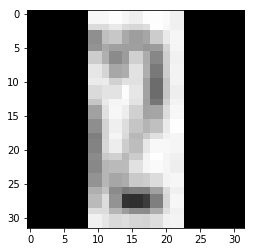

In [43]:
plt.imshow(images[9].numpy()[0], cmap='gray')

In [10]:
def error_rate(loader, model, sample_rate=0.1):
    err = []
    for batch_idx, (images, labels) in enumerate(loader):
        if batch_idx > len(loader) * sample_rate: break
        output = net(Variable(images))
        output = np.argmax(output.data.numpy(), axis=1)
        err.append(np.sum(output != labels.squeeze().numpy()) * 1.0 / len(output))
    return np.mean(err)

        
net = Net()
# data_iter = iter(train_loader)

# mini-batch 图像 和 标签
# images, labels = next(data_iter)

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.01)
num_epoch = 1000

test_acc_arr = []

# in your training loop:
for i in range(num_epoch):
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad() # zero the gradient buffers，如果不归0的话，gradients会累加

        output = net(Variable(images)) # 这里就体现出来动态建图了，你还可以传入其他的参数来改变网络的结构\
        target = Variable(labels).squeeze().long()

        loss = F.nll_loss(output, target)
        loss.backward() # 得到grad，i.e.给Variable.grad赋值
        optimizer.step() # Does the update，i.e. Variable.data -= learning_rate*Variable.grad

        if not batch_idx % 300:
            print('Epoch {} batch {}: loss {}'.format(i, batch_idx, loss))
            print('Training acc: {}'.format(1.0 - error_rate(train_loader, net)))
    test_acc = 1.0 - error_rate(test_loader, net)
    print('Test acc: {}'.format(test_acc))
    test_acc_arr.append(test_acc)
    if test_acc > 0.6:
        save(net, 'cropped_vanilla_model_epoch_{}.pkl'.format(i))
        if len(test_acc_arr) > 3 and test_acc_arr[-1] < test_acc_arr[-2] < test_acc_arr[-3] < test_acc_arr[-4]:
            print('Test acc going down consecutively 3 times, stop training')
            break


Epoch 0 batch 0: loss Variable containing:
 2.3031
[torch.FloatTensor of size 1]

Training acc: 0.147567567568
Epoch 0 batch 300: loss Variable containing:
 2.2459
[torch.FloatTensor of size 1]

Training acc: 0.193243243243
Epoch 0 batch 600: loss Variable containing:
 2.2456
[torch.FloatTensor of size 1]

Training acc: 0.200675675676
Test acc: 0.231481481481
Epoch 1 batch 0: loss Variable containing:
 2.2056
[torch.FloatTensor of size 1]

Training acc: 0.206486486486
Epoch 1 batch 300: loss Variable containing:
 2.0072
[torch.FloatTensor of size 1]

Training acc: 0.237432432432
Epoch 1 batch 600: loss Variable containing:
 2.1785
[torch.FloatTensor of size 1]

Training acc: 0.244324324324
Test acc: 0.24
Epoch 2 batch 0: loss Variable containing:
 2.1580
[torch.FloatTensor of size 1]

Training acc: 0.237837837838
Epoch 2 batch 300: loss Variable containing:
 2.0630
[torch.FloatTensor of size 1]

Training acc: 0.246756756757
Epoch 2 batch 600: loss Variable containing:
 2.1381
[torch.Fl

/Users/jtao/miniconda2/lib/python2.7/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 15 batch 0: loss Variable containing:
 1.1463
[torch.FloatTensor of size 1]

Training acc: 0.700945945946
Epoch 15 batch 300: loss Variable containing:
 0.8621
[torch.FloatTensor of size 1]

Training acc: 0.72472972973
Epoch 15 batch 600: loss Variable containing:
 0.7495
[torch.FloatTensor of size 1]

Training acc: 0.746216216216
Test acc: 0.703333333333
Epoch 16 batch 0: loss Variable containing:
 0.8727
[torch.FloatTensor of size 1]

Training acc: 0.756351351351
Epoch 16 batch 300: loss Variable containing:
 0.8407
[torch.FloatTensor of size 1]

Training acc: 0.758243243243
Epoch 16 batch 600: loss Variable containing:
 0.8409
[torch.FloatTensor of size 1]

Training acc: 0.746081081081
Test acc: 0.744444444444
Epoch 17 batch 0: loss Variable containing:
 0.7105
[torch.FloatTensor of size 1]

Training acc: 0.777162162162
Epoch 17 batch 300: loss Variable containing:
 0.7482
[torch.FloatTensor of size 1]

Training acc: 0.780945945946
Epoch 17 batch 600: loss Variable containing:

Training acc: 0.86527027027
Epoch 37 batch 600: loss Variable containing:
 0.4431
[torch.FloatTensor of size 1]

Training acc: 0.872837837838
Test acc: 0.824444444444
Epoch 38 batch 0: loss Variable containing:
 0.2488
[torch.FloatTensor of size 1]

Training acc: 0.880540540541
Epoch 38 batch 300: loss Variable containing:
 0.3258
[torch.FloatTensor of size 1]

Training acc: 0.886081081081
Epoch 38 batch 600: loss Variable containing:
 0.4447
[torch.FloatTensor of size 1]

Training acc: 0.884864864865
Test acc: 0.835185185185
Epoch 39 batch 0: loss Variable containing:
 0.3717
[torch.FloatTensor of size 1]

Training acc: 0.878378378378
Epoch 39 batch 300: loss Variable containing:
 0.3300
[torch.FloatTensor of size 1]

Training acc: 0.887567567568
Epoch 39 batch 600: loss Variable containing:
 0.4117
[torch.FloatTensor of size 1]

Training acc: 0.873918918919
Test acc: 0.850740740741
Epoch 40 batch 0: loss Variable containing:
 0.4600
[torch.FloatTensor of size 1]

Training acc: 0.8855

In [51]:
import torch
torch.__version__

'0.2.0_4'

In [72]:
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
# model = load('vanilla_model_epoch_60.pkl')
model = load('cropped_vanilla_model_epoch_39.pkl')

In [43]:
tensor = file2tensor('clocks/num11.png')
predict_image(tensor, model)

[[  6.48642704e-02   1.57538409e-04   5.22932062e-08   1.33300069e-04
    6.29064045e-09   5.89202112e-03   9.27175045e-01   5.04703030e-06
    1.74215983e-03   3.05864123e-05]]


array([6])

In [24]:
np.exp([0, 1])

array([ 1.        ,  2.71828183])

In [23]:
aa = np.random.rand(3, 4)
aa

array([[0.18172115, 0.81269883, 0.30181448, 0.8013887 ],
       [0.51834583, 0.0633119 , 0.1472658 , 0.07491638],
       [0.46951932, 0.97698501, 0.54223489, 0.23656321]])

In [24]:
np.argmax(aa, axis=0)

array([1, 2, 2, 0])

In [21]:
map(lambda x:x+1, [1,2])

[2, 3]

In [9]:
img = Image.open('/Users/jtao/Downloads/train/1.png')

In [13]:
croped = img.crop((246,77,246+81,77+219))

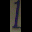

In [14]:
pad_img(croped)

In [58]:
import os
root = '/Users/jtao/Downloads/train_agg'
for dire in os.listdir(root):
    dire = os.path.join(root, dire)
    if os.path.isdir(dire):
        print('{} has {} files'.format(dire, len(os.listdir(dire))))

/Users/jtao/Downloads/train_agg/9 has 4659 files
/Users/jtao/Downloads/train_agg/0 has 4948 files
/Users/jtao/Downloads/train_agg/7 has 5595 files
/Users/jtao/Downloads/train_agg/6 has 5727 files
/Users/jtao/Downloads/train_agg/1 has 13861 files
/Users/jtao/Downloads/train_agg/8 has 5045 files
/Users/jtao/Downloads/train_agg/4 has 7458 files
/Users/jtao/Downloads/train_agg/3 has 8497 files
/Users/jtao/Downloads/train_agg/2 has 10585 files
/Users/jtao/Downloads/train_agg/5 has 6882 files
